In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
from imblearn.over_sampling import SMOTE
from Functions import *

In [2]:
data = pd.read_csv("clean.csv")
X = data.drop("Response", axis=1)
y = data["Response"]
X_encoded = pd.get_dummies(X,drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Base

In [3]:
svm = SVC(kernel="linear", probability=True,verbose=True)
# model = SVC(kernel='rbf', gamma='scale')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

y_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_svm)
auc_base = roc_auc_score(y_test, y_prob_svm)

print("SVM-Base AUC Score: ", auc_base)
print(classification_report(y_test, y_pred_svm))

[LibSVM]SVM-Base AUC Score:  0.47768177768177766
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7735
           1       0.00      0.00      0.00      2442

    accuracy                           0.76     10177
   macro avg       0.38      0.50      0.43     10177
weighted avg       0.58      0.76      0.66     10177



### SMOTE

In [4]:
# Apply SMOTE
print("Before SMOTE - Class distribution:", dict(pd.Series(y_train).value_counts()))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE - Class distribution:", dict(pd.Series(y_train_resampled).value_counts()))

# Model Training
svm = SVC(kernel="linear", probability=True)
# model = SVC(kernel='rbf', gamma='scale')
svm.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm.predict(X_test_scaled)

y_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]
fpr_sm, tpr_sm, _ = roc_curve(y_test, y_prob_svm)
auc_sm = roc_auc_score(y_test, y_prob_svm)

print("SVM-Base AUC Score: ", auc_sm)
print(classification_report(y_test, y_pred_svm))

Before SMOTE - Class distribution: {0: 30938, 1: 9767}
After SMOTE - Class distribution: {0: 30938, 1: 30938}
SVM-Base AUC Score:  0.5628843334725687
              precision    recall  f1-score   support

           0       0.82      0.29      0.43      7735
           1       0.26      0.80      0.40      2442

    accuracy                           0.41     10177
   macro avg       0.54      0.55      0.41     10177
weighted avg       0.69      0.41      0.42     10177



### Hyperparameter Tuning

In [10]:
data = pd.read_csv("clean.csv")
X = data.drop("Response", axis=1)
y = data["Response"]
X_encoded = pd.get_dummies(X,drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# SVM - hyperparameter tuning
param_grid_svm = {
    'C': [0.1,0.5],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
}
grid_svm = GridSearchCV(
    SVC(probability=True),
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=3,
    verbose=2
)
grid_svm.fit(X_train_scaled, y_train)
y_pred_svm_hyper = grid_svm.predict(X_test_scaled)
print("Best SVM params:", grid_svm.best_params_)
print("Best Score：", grid_svm.best_score_)

# Access performace
best_svm = grid_svm.best_estimator_
y_pred = best_svm.predict(X_test_scaled)
y_prob_best_svm = best_svm.predict_proba(X_test_scaled)[:, 1]
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_best_svm)
auc_tuned = roc_auc_score(y_test, y_prob_best_svm)

print("SVM Performance：")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("SVM AUC Score: ", auc_tuned)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 2.0min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 2.0min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 2.0min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time= 3.0min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time= 2.9min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time= 2.9min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 2.1min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 2.0min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 2.1min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=rbf; total time= 3.0min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=rbf; total time= 2.9min
[CV] END C=0.1

In [ ]:
y_pred_svm_hyper = grid_svm.predict(X_test_scaled)
print("Best SVM params:", grid_svm.best_params_)
print("Best Score：", grid_svm.best_score_)

# Access performace
best_svm = grid_svm.best_estimator_
y_pred = best_svm.predict(X_test_scaled)
y_prob_best_svm = best_svm.predict_proba(X_test_scaled)[:, 1]
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_best_svm)
auc_tuned = roc_auc_score(y_test, y_prob_best_svm)

print("SVM Performance：")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("SVM AUC Score: ", auc_tuned)

### Feature Engineering

#### Method 1 - Smooth

In [5]:
data = pd.read_csv("clean.csv")
X = data.drop(columns=["Response","ID","Unnamed: 0"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_final, X_test_final, train_data_Response, y_test = train_smooth_encoding_model(X_train, y_train, X_test, y_test, weight=100)

svm = SVC(kernel="linear", probability=True,class_weight="balanced")
svm.fit(X_train_final, y_train)
y_pred_svm = svm.predict(X_test_final)

y_prob_svm = svm.predict_proba(X_test_final)[:, 1]
fpr_fe1, tpr_fe1, _ = roc_curve(y_test, y_prob_svm)
auc_fe1 = roc_auc_score(y_test, y_prob_svm)

print("AUC Score: ", auc_fe1)
print(classification_report(y_test, y_pred_svm))

================== Smooth Encoding ==================
AUC Score:  0.5910830028477088
              precision    recall  f1-score   support

           0       0.80      0.61      0.69      7735
           1       0.29      0.51      0.37      2442

    accuracy                           0.59     10177
   macro avg       0.55      0.56      0.53     10177
weighted avg       0.68      0.59      0.62     10177



#### Method 2 - Bayesian

In [6]:
data = pd.read_csv("clean.csv")
X = data.drop(columns=["Response","ID","Unnamed: 0"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_final, X_test_final, train_data_Response, y_test = train_bayesian_encoding_model(X_train, y_train, X_test, y_test)

svm = SVC(kernel="linear", probability=True,class_weight="balanced")
svm.fit(X_train_final, y_train)
y_pred_svm = svm.predict(X_test_final)

y_prob_svm = svm.predict_proba(X_test_final)[:, 1]
fpr_fe2, tpr_fe2, _ = roc_curve(y_test, y_prob_svm)
auc_fe2 = roc_auc_score(y_test, y_prob_svm)

print("AUC Score: ", auc_fe2)
print(classification_report(y_test, y_pred_svm))

============================== Bayesian ==============================
AUC Score:  0.5743833802657332
              precision    recall  f1-score   support

           0       0.79      0.61      0.69      7735
           1       0.28      0.49      0.36      2442

    accuracy                           0.58     10177
   macro avg       0.54      0.55      0.53     10177
weighted avg       0.67      0.58      0.61     10177



#### Method 3 - K Fold

In [7]:
data = pd.read_csv("clean.csv")
X = data.drop(columns=["Response","ID","Unnamed: 0"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_final, X_test_final, train_data_Response, y_test = train_kfold_encoding_model(X_train, y_train, X_test, y_test)

svm = SVC(kernel="linear", probability=True,class_weight="balanced")
svm.fit(X_train_final, y_train)
y_pred_svm = svm.predict(X_test_final)

y_prob_svm = svm.predict_proba(X_test_final)[:, 1]
fpr_fe3, tpr_fe3, _ = roc_curve(y_test, y_prob_svm)
auc_fe3 = roc_auc_score(y_test, y_prob_svm)

print("AUC Score: ", auc_fe3)
print(classification_report(y_test, y_pred_svm))

============================== K Fold ==============================
AUC Score:  0.6217190599543541
              precision    recall  f1-score   support

           0       0.82      0.55      0.66      7735
           1       0.30      0.61      0.40      2442

    accuracy                           0.57     10177
   macro avg       0.56      0.58      0.53     10177
weighted avg       0.69      0.57      0.60     10177



#### K Fold + SMOTE

In [8]:
data = pd.read_csv("clean.csv")
X = data.drop(columns=["Response","ID","Unnamed: 0"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_final, X_test_final, train_data_Response, y_test = train_kfold_encoding_model(X_train, y_train, X_test, y_test)

svm = SVC(kernel="linear", probability=True,class_weight="balanced")
svm.fit(X_train_final, y_train)
y_pred_svm = svm.predict(X_test_final)

y_prob_svm = svm.predict_proba(X_test_final)[:, 1]
fpr_fe4, tpr_fe4, _ = roc_curve(y_test, y_prob_svm)
auc_fe4 = roc_auc_score(y_test, y_prob_svm)

print("AUC Score: ", auc_fe4)
print(classification_report(y_test, y_pred_svm))

============================== K Fold ==============================
AUC Score:  0.6217186893657481
              precision    recall  f1-score   support

           0       0.82      0.55      0.66      7735
           1       0.30      0.61      0.40      2442

    accuracy                           0.57     10177
   macro avg       0.56      0.58      0.53     10177
weighted avg       0.69      0.57      0.60     10177



#### KFold + Hyperparameter Tuning

In [9]:
data = pd.read_csv("clean.csv")
X = data.drop(columns=["Response","ID","Unnamed: 0"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_final, X_test_final, train_data_Response, y_test = train_kfold_encoding_model(X_train, y_train, X_test, y_test)

# SVM - hyperparameter tuning
param_grid_svm = {
    'C': [0.1,0.5],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
}
grid_svm = GridSearchCV(
    SVC(probability=True),
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=3,
    verbose=2
)
grid_svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_final)

y_prob_svm = svm.predict_proba(X_test_final)[:, 1]
fpr_fe5, tpr_fe5, _ = roc_curve(y_test, y_prob_svm)
auc_fe5 = roc_auc_score(y_test, y_prob_svm)

print("AUC Score: ", auc_fe5)
print(classification_report(y_test, y_pred_svm))

============================== K Fold ==============================
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 6.4min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 1.9min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 1.9min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time= 3.2min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=10.7min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=10.9min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 8.2min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 7.6min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 7.6min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=rbf; total time= 9.7min
[CV] END C=0.1, class_weigh

#### Tuning plot

In [4]:
def plot_tuning_trend(grid_search, model_name="Model"):
    results = grid_search.cv_results_
    plt.figure(figsize=(18, 5))
    plt.plot(range(len(results['params'])), results['mean_test_score'],
            'o-', linewidth=2, markersize=8, color='blue', label='Mean AUC')

    plt.fill_between(range(len(results['params'])),
                    results['mean_test_score'] - results['std_test_score'],
                    results['mean_test_score'] + results['std_test_score'],
                    alpha=0.2, color='blue', label='±1 std')

    best_idx = np.argmax(results['mean_test_score'])
    plt.plot(best_idx, results['mean_test_score'][best_idx], 'ro',
            markersize=12, label='Best Combination')

    plt.xlabel('Parameter Combination Index', fontsize=12)
    plt.ylabel('AUC Score', fontsize=12)
    plt.title(f'{model_name} Hyperparameter Tuning Performance Trend', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.annotate(f'Best: {results["mean_test_score"][best_idx]:.4f}',
                xy=(best_idx, results['mean_test_score'][best_idx]),
                xytext=(best_idx+2, results['mean_test_score'][best_idx]-0.02),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10, color='red')

    plt.tight_layout()
    plt.show()

    return best_idx

============================== K Fold ==============================
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 3.1min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 4.5min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=linear; total time= 5.1min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time= 8.4min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time= 8.3min
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time= 2.3min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 1.3min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 1.3min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=linear; total time= 5.0min
[CV] END C=0.1, class_weight=balanced, gamma=auto, kernel=rbf; total time= 5.7min
[CV] END C=0.1, class_weigh

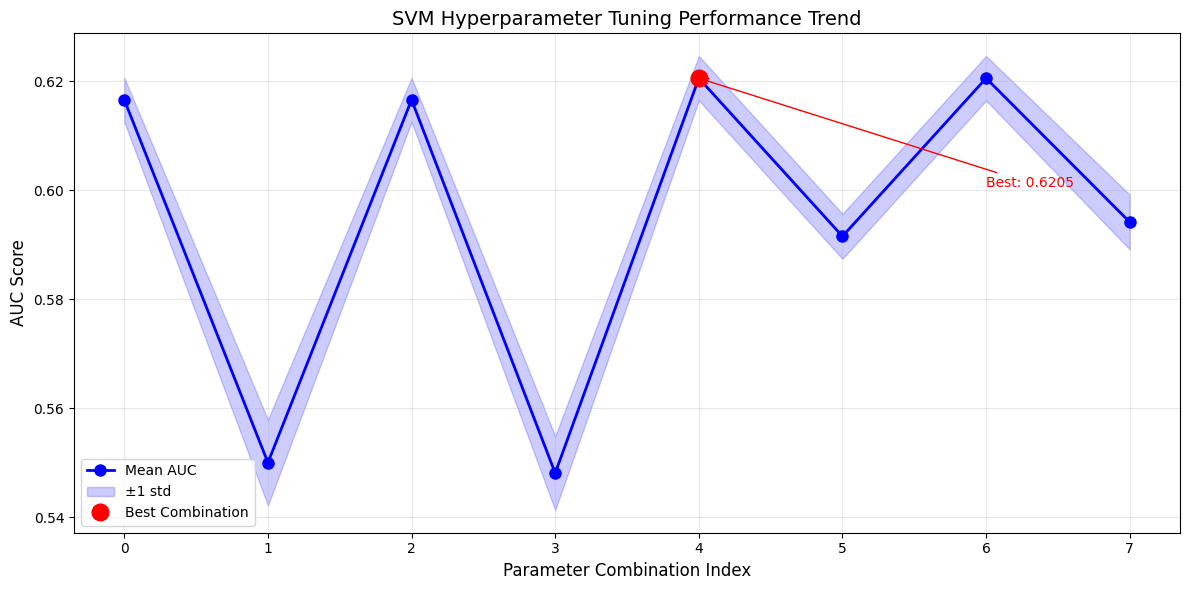

Best SVM Parameters: {'C': 0.5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best SVM AUC Score: 0.6205
AUC Score:  0.6216325804561098
              precision    recall  f1-score   support

           0       0.82      0.55      0.66      7735
           1       0.30      0.62      0.40      2442

    accuracy                           0.56     10177
   macro avg       0.56      0.58      0.53     10177
weighted avg       0.69      0.56      0.60     10177



In [3]:
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv("clean.csv")
X = data.drop(columns=["Response","ID","Unnamed: 0"])
y = data["Response"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train_final, X_test_final, train_data_Response, y_test = train_kfold_encoding_model(X_train, y_train, X_test, y_test)

# SVM - hyperparameter tuning
param_grid_svm = {
    'C': [0.1, 0.5],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
}
grid_svm = GridSearchCV(
    SVC(probability=True),
    param_grid=param_grid_svm,
    scoring='roc_auc',
    cv=3,
    verbose=2
)
grid_svm.fit(X_train_final, y_train)

best_idx = plot_tuning_trend(grid_svm, model_name="SVM")

print(f"Best SVM Parameters: {grid_svm.best_params_}")
print(f"Best SVM AUC Score: {grid_svm.best_score_:.4f}")

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_final)
y_prob_svm = best_svm.predict_proba(X_test_final)[:, 1]

fpr_fe5, tpr_fe5, _ = roc_curve(y_test, y_prob_svm)
auc_fe5 = roc_auc_score(y_test, y_prob_svm)

print("AUC Score: ", auc_fe5)
print(classification_report(y_test, y_pred_svm))

### ROC

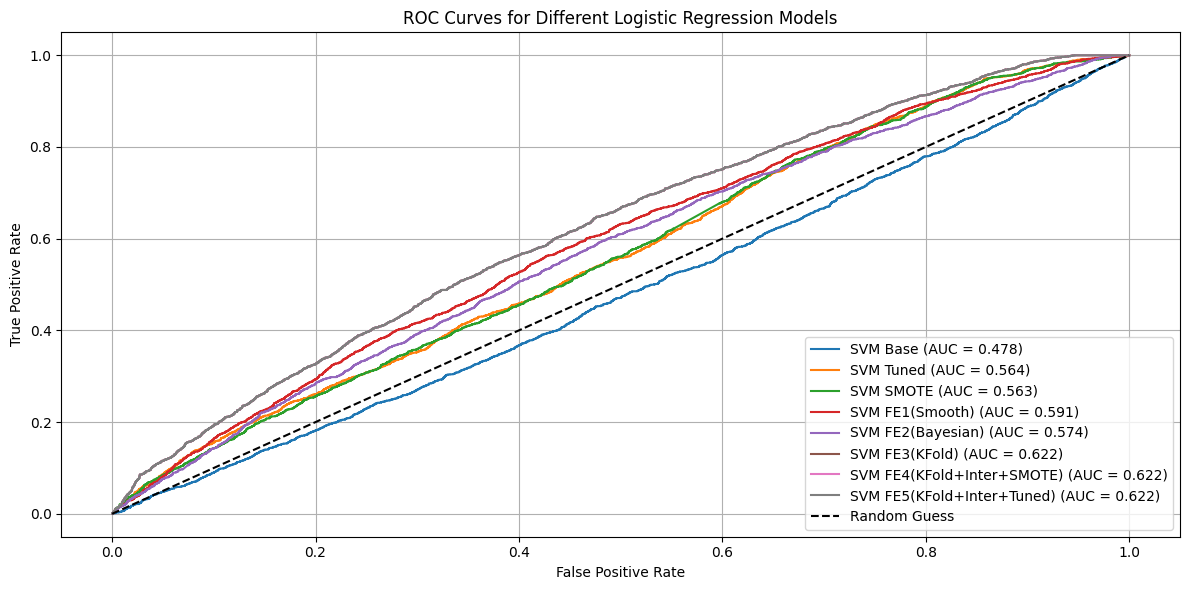

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(fpr_base,  tpr_base,  label=f"SVM Base (AUC = {auc_base:.3f})")
plt.plot(fpr_tuned,  tpr_tuned,  label=f"SVM Tuned (AUC = {auc_tuned:.3f})")
plt.plot(fpr_sm,  tpr_sm,  label=f"SVM SMOTE (AUC = {auc_sm:.3f})")
plt.plot(fpr_fe1,  tpr_fe1,  label=f"SVM FE1(Smooth) (AUC = {auc_fe1:.3f})")
plt.plot(fpr_fe2,  tpr_fe2,  label=f"SVM FE2(Bayesian) (AUC = {auc_fe2:.3f})")
plt.plot(fpr_fe3,  tpr_fe3,  label=f"SVM FE3(KFold) (AUC = {auc_fe3:.3f})")
plt.plot(fpr_fe4, tpr_fe4, label=f"SVM FE4(KFold+Inter+SMOTE) (AUC = {auc_fe4:.3f})")
plt.plot(fpr_fe5, tpr_fe5, label=f"SVM FE5(KFold+Inter+Tuned) (AUC = {auc_fe5:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Logistic Regression Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()